# ERA5 HI, WBGT & Air Temps
Cascade Tuholske, Oct 2024

This is a notebook to generate daily maximum heat index, maximum indoor/shared wet blube globe temperature and daily minimum/maximum air temperature using ERA5 Land climate reanalysis. The data can be downloaed from [ECWMF](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=download).

Here we are using hour dew point temperature, 2 meter air temperature, and surface pressure for July 2020. We have selected a spatial extent covering Ghana. The file is downloaded in a `NetCDF` format so that we can use `Xarray` to process the data.

While there are many heat stress metrics, we are going to use heat index and an approximated shade wet bulb globe temperature. You can read about the conversion of HI to WBGT [here](https://www.tandfonline.com/doi/abs/10.1080/15459624.2014.989365?casa_token=sExUV3cSMu0AAAAA:xGVypJnWLDwg4hvnAoAET8Hvn0_v_dca-IojLQ1jyuqrekH9_QsO6BW1djKQY9mYLgRX-aI5Rwxmcw).  

Below is a referesher on `Xarray` data structures:

#### Understanding Xarray's Data Structures

Xarray introduces two main data structures: `DataArray` and `Dataset`. These structures are built on top of NumPy and pandas. We recommend you read about [`Xarray` data structures](https://docs.xarray.dev/en/stable/user-guide/data-structures.html) because the terminology can be a bit confusing

A `DataArray` is Xarray’s implementation of a labeled, multi-dimensional array. 

- Values: a numpy.ndarray or numpy-like array holding the array’s values
- Dimensions: These are names for each axis of the array. For instance, in climate data, common dimensions include 'time', 'latitude', and 'longitude'.
- Coordinates: These are arrays that label each point, such as specific dates for the 'time' dimension or longitude and latitude values for geographical dimensions. Coordinates enable powerful and intuitive data selections.
- Attributes: These are metadata for the array, used to store arbitrary metadata such as the description of the dataset, units of measurement, or other relevant information.

A `Dataset` is a dictionary-like container that holds multiple variables (arrays) that potentially share the same coordinates. It is analogous to a pandas DataFrame but can handle multi-dimensional data. Each variable in a Dataset is itself a DataArray.

![ntl](./assets/xarray.png) <br>

Basically, `Xarray` allows you to create labeled n-dimentional numpy arrays. So you can label your datasets (temperature, precipitation, etc.) and your dimentions (time, lat/long, etc.) to easily subset the data to run analysis. For example, you could say, what is the average heat index in Accra based on Lat/Long with just a few lines of code. **Note** We will use the package [`rioxarray`](https://corteva.github.io/rioxarray/html/rioxarray.html) too to load in the GeoTiff files. More on this later.   

### Let's get started!
<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [1]:
# Dependencies 
import os
import glob 
import xarray as xr
import dask
import rioxarray as rio
import pandas as pd
import numpy as np
import rasterio
import ClimFuncs as cf
from atmos import moisture
from atmos import thermo
from atmos.moisture import relative_humidity_from_dewpoint_temperature as rh
import matplotlib.pyplot as plt

### Open the NetCDF File as an Xarray Dataset

In [2]:
fn = os.path.join('./data/ERA5-Ghana-Hourly-202007-td-t-p.nc')
ds = xr.open_dataset(fn, chunks = 'auto')

In [3]:
ds.t2m

<xarray.DataArray 't2m' (valid_time: 744, latitude: 71, longitude: 81)> Size: 17MB
dask.array<open_dataset-t2m, shape=(744, 71, 81), dtype=float32, chunksize=(744, 71, 81), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-07-01 ... 2020-07-31T23:...
  * latitude    (latitude) float64 568B 11.0 10.9 10.8 10.7 ... 4.3 4.2 4.1 4.0
  * longitude   (longitude) float64 648B -3.5 -3.4 -3.3 -3.2 ... 4.2 4.3 4.4 4.5
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      5751
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [4]:
# load the data into memory
ds = ds.load()
ds

<xarray.Dataset> Size: 51MB
Dimensions:     (valid_time: 744, latitude: 71, longitude: 81)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-07-01 ... 2020-07-31T23:...
  * latitude    (latitude) float64 568B 11.0 10.9 10.8 10.7 ... 4.3 4.2 4.1 4.0
  * longitude   (longitude) float64 648B -3.5 -3.4 -3.3 -3.2 ... 4.2 4.3 4.4 4.5
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    d2m         (valid_time, latitude, longitude) float32 17MB 295.5 ... nan
    t2m         (valid_time, latitude, longitude) float32 17MB 297.9 ... nan
    sp          (valid_time, latitude, longitude) float32 17MB 9.775e+04 ... nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-03T02:44 GRIB to CDM+CF via cfgrib-0.9.1...

### Check the data
Notice that the temperature data is in Kelvin ...

In [5]:
arr = ds.d2m.isel(valid_time = 1)

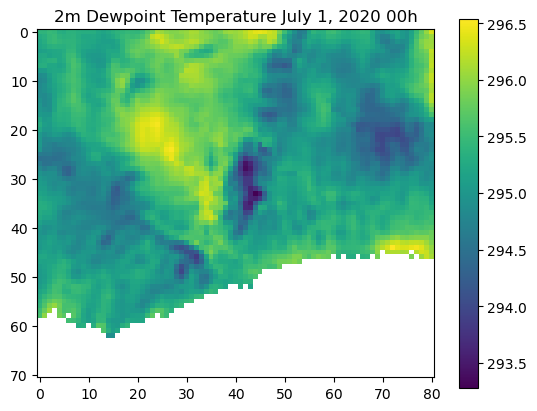

In [6]:
plt.imshow(arr)
plt.title('2m Dewpoint Temperature July 1, 2020 00h')
plt.colorbar();

In [7]:
arr = ds.t2m.isel(valid_time = 1)

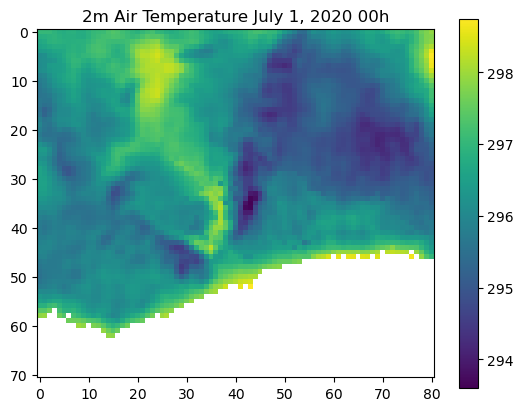

In [8]:
plt.imshow(arr)
plt.title('2m Air Temperature July 1, 2020 00h')
plt.colorbar();

# Estimate Relative Humidity 

In [9]:
ds['rh'] = 100 * xr.apply_ufunc(rh, ds.t2m, ds.d2m) # multiply by 100 since output is in decimals 

In [10]:
ds

<xarray.Dataset> Size: 68MB
Dimensions:     (valid_time: 744, latitude: 71, longitude: 81)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-07-01 ... 2020-07-31T23:...
  * latitude    (latitude) float64 568B 11.0 10.9 10.8 10.7 ... 4.3 4.2 4.1 4.0
  * longitude   (longitude) float64 648B -3.5 -3.4 -3.3 -3.2 ... 4.2 4.3 4.4 4.5
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    d2m         (valid_time, latitude, longitude) float32 17MB 295.5 ... nan
    t2m         (valid_time, latitude, longitude) float32 17MB 297.9 ... nan
    sp          (valid_time, latitude, longitude) float32 17MB 9.775e+04 ... nan
    rh          (valid_time, latitude, longitude) float32 17MB 86.96 ... nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-03T02:44 GRIB to CDM+CF via cfgrib-0.9.1...

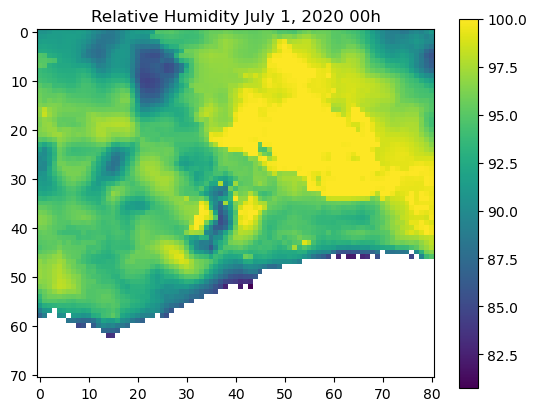

In [11]:
# plot rh
arr = ds.rh.isel(valid_time = 1)
plt.imshow(arr)
plt.title('Relative Humidity July 1, 2020 00h')
plt.colorbar();

# Estimate Heat Index & WBGT

In [12]:
def make_hi_wbgt(ds):
    """
    Calculate heat index (HI) and wet-bulb globe temperature (WBGT) from a dataset containing temperature and relative humidity.

    This function takes a dataset (`ds`) with temperature in Kelvin and relative humidity (RH), converts temperature 
    to Celsius and Fahrenheit, computes the heat index in Fahrenheit, converts it back to Celsius, and calculates the 
    wet-bulb globe temperature. The computed values are added as new variables to the dataset.

    Parameters
    ----------
    ds : xarray.Dataset
        An xarray dataset containing at least two variables:
        - `t2m` : Temperature in Kelvin.
        - `rh`  : Relative humidity as a percentage.

    Returns
    -------
    xarray.Dataset
        The input dataset with added variables:
        - `t2m_c` : Temperature in Celsius.
        - `t2m_f` : Temperature in Fahrenheit.
        - `hi`    : Heat index in Celsius.
        - `wbgt`  : Wet-bulb globe temperature in Celsius.

    Notes
    -----
    The function assumes that:
    - Temperature in Kelvin (`t2m`) is converted to Celsius and Fahrenheit.
    - Heat index (`hi`) is calculated in Fahrenheit and then converted back to Celsius.
    - Wet-bulb globe temperature (`wbgt`) is derived from the heat index.
    
    Requires the `cf` module for temperature and heat index conversions.
    """
    ds['t2m_c'] = ds.t2m - 273.15
    ds['t2m_f'] = xr.apply_ufunc(cf.C_to_F, ds.t2m_c)
    ds['hi'] = cf.heatindex(ds.t2m_f, ds.rh, 'F', 'F')
    ds['wbgt'] = xr.apply_ufunc(cf.hi_to_wbgt, ds.hi)
    ds['hi'] = xr.apply_ufunc(cf.F_to_C, ds.hi)
    
    return ds

In [13]:
ds = make_hi_wbgt(ds)

In [14]:
ds.wbgt.max(dim = 'valid_time')

<xarray.DataArray 'wbgt' (latitude: 71, longitude: 81)> Size: 46kB
array([[28.47672963, 28.42768651, 28.47412886, ..., 28.3678084 ,
        28.28239921, 28.38966703],
       [28.2885868 , 28.26444986, 28.40618946, ..., 28.38344393,
        28.1831455 , 28.07954182],
       [28.1387406 , 28.19535367, 28.3271785 , ..., 28.46410446,
        28.22329733, 28.0133181 ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 568B 11.0 10.9 10.8 10.7 ... 4.3 4.2 4.1 4.0
  * longitude  (longitude) float64 648B -3.5 -3.4 -3.3 -3.2 ... 4.2 4.3 4.4 4.5

### Check the data
Let's look at the hi and wbgt data

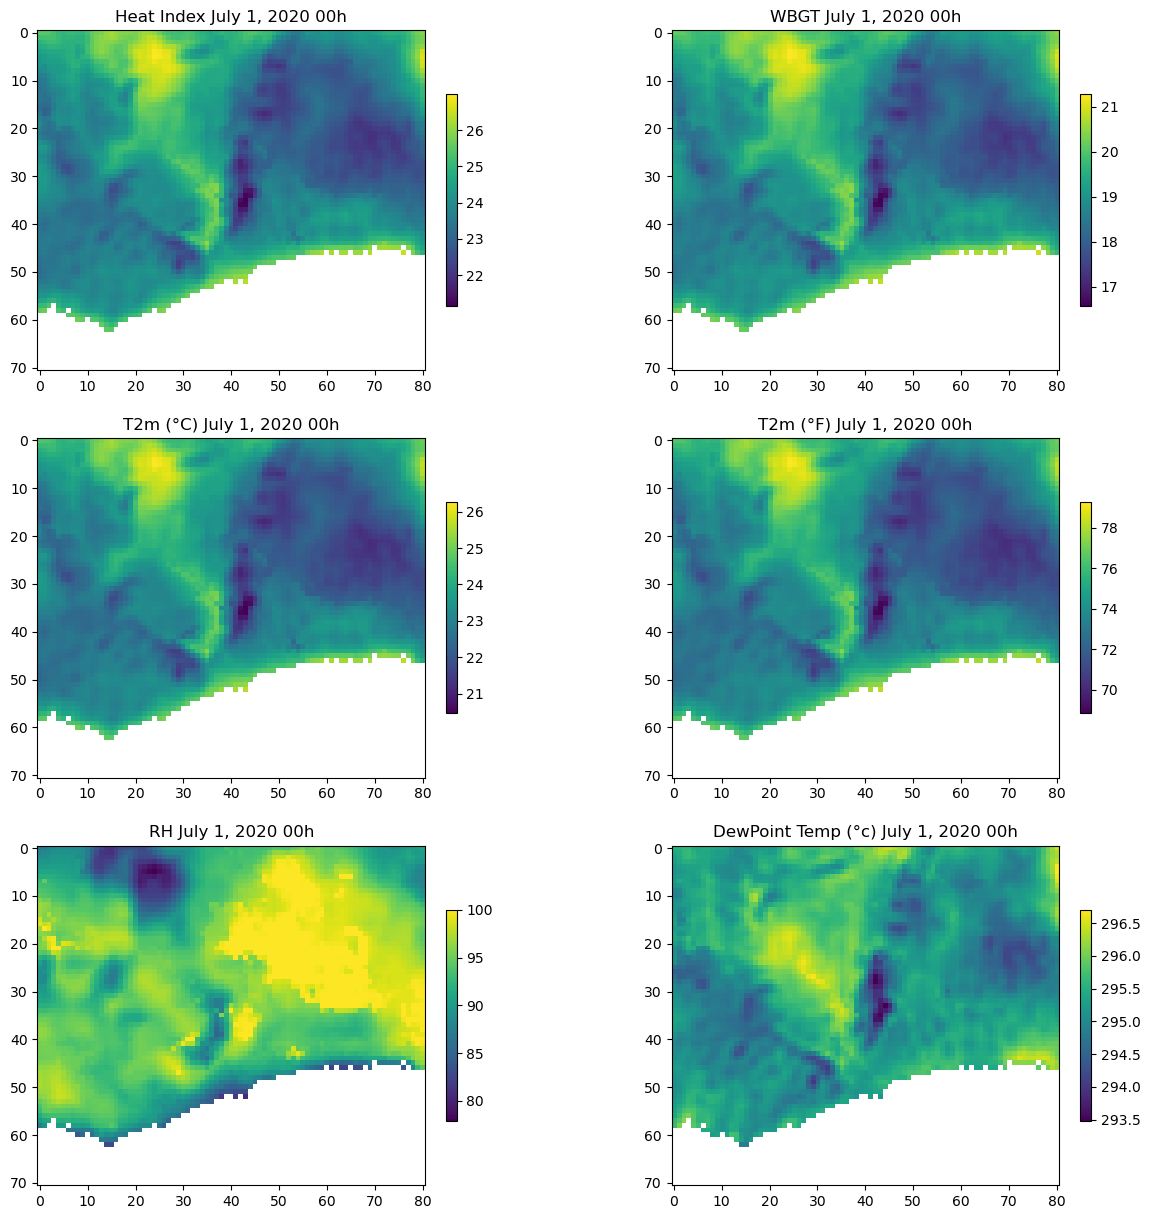

In [16]:
# Define subplots with smaller size
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 2 row, 2 columns

arr = ds.hi.isel(valid_time = 0)
p1 = axs[0][0].imshow(arr)
cbar = fig.colorbar(p1, ax=axs[0][0], orientation='vertical', fraction=0.02, pad=0.04)
axs[0][0].set_title('Heat Index July 1, 2020 00h');

arr = ds.wbgt.isel(valid_time = 0)
p1 = axs[0][1].imshow(arr)
cbar = fig.colorbar(p1, ax=axs[0][1], orientation='vertical', fraction=0.02, pad=0.04)
axs[0][1].set_title('WBGT July 1, 2020 00h');

arr = ds.t2m_c.isel(valid_time = 0)
p1 = axs[1][0].imshow(arr)
cbar = fig.colorbar(p1, ax=axs[1][0], orientation='vertical', fraction=0.02, pad=0.04)
axs[1][0].set_title('T2m (°C) July 1, 2020 00h');

arr = ds.t2m_f.isel(valid_time = 0)
p1 = axs[1][1].imshow(arr)
cbar = fig.colorbar(p1, ax=axs[1][1], orientation='vertical', fraction=0.02, pad=0.04)
axs[1][1].set_title('T2m (°F) July 1, 2020 00h');

arr = ds.rh.isel(valid_time = 0)
p1 = axs[2][0].imshow(arr)
cbar = fig.colorbar(p1, ax=axs[2][0], orientation='vertical', fraction=0.02, pad=0.04)
axs[2][0].set_title('RH July 1, 2020 00h');

arr = ds.d2m.isel(valid_time = 0)
p1 = axs[2][1].imshow(arr)
cbar = fig.colorbar(p1, ax=axs[2][1], orientation='vertical', fraction=0.02, pad=0.04)
axs[2][1].set_title('DewPoint Temp (°c) July 1, 2020 00h');

In [17]:
arr = ds.hi.isel(valid_time = 14)

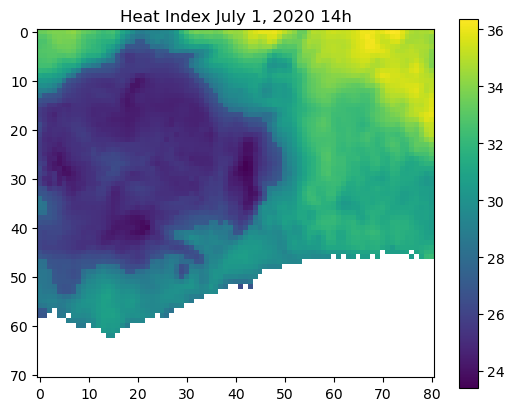

In [19]:
plt.imshow(arr)
plt.title('Heat Index July 1, 2020 14h');
plt.colorbar();

In [20]:
arr = ds.wbgt.isel(valid_time = 1)

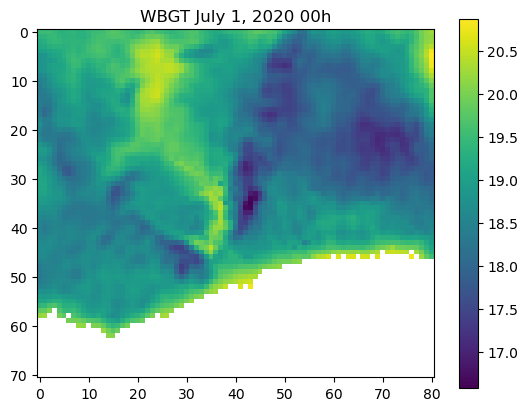

In [21]:
plt.imshow(arr)
plt.title('WBGT July 1, 2020 00h')
plt.colorbar()

# Daily Max
Now, let's select the daily maximum heat index, wet bulb glob temperature, min/max air temperature.

In [22]:
# Select the daily values
tmin = ds.t2m_c.resample(valid_time='1D').min(dim = 'valid_time')
tmax = ds.t2m_c.resample(valid_time='1D').max(dim = 'valid_time')
himax = ds.hi.resample(valid_time='1D').max(dim = 'valid_time')
wbgtmax = ds.wbgt.resample(valid_time='1D').max(dim = 'valid_time')

In [23]:
# rename tmin, tmax, himax, and wbgtmax
tmin = tmin.rename('tmin')
tmax = tmax.rename('tmax')
himax = himax.rename('himax')
wbgtmax = tmax.rename('wbgtmax')

In [26]:
# take a look
himax

<xarray.DataArray 'himax' (valid_time: 31, latitude: 71, longitude: 81)> Size: 1MB
array([[[33.68900299, 33.75981649, 33.9204322 , ..., 35.14171176,
         35.00677745, 35.0104777 ],
        [33.34668477, 33.42755636, 33.67968665, ..., 34.96136136,
         34.65527852, 34.32652791],
        [33.13613044, 33.26406691, 33.47520192, ..., 34.91010878,
         34.55892351, 34.24536387],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[36.96064843, 36.99940575, 37.05892775, ..., 38.51958381,
         38.33057827, 38.38520898],
        [36.4584181 , 36.54407925, 36.7286555 , ..., 38.55166965,
         38.11367459, 37.72419824],
        [36.06680128, 36.2541114 , 36.53939989, ..., 38.71793959,
         38.22520362, 37.6514562 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[34.6859063 , 34.67593723, 34.62411245, ..., 33.40516408,
         33.24003855, 33.12058767],
        [34.51802572, 34.51650831, 34.59733751, ..., 33.37947845,
         33.01324209, 32.64547136],
        [34.43459829, 34.48950873, 34.67980703, ..., 33.58740065,
         33.17848629, 32.74321238],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 568B 11.0 10.9 10.8 10.7 ... 4.3 4.2 4.1 4.0
  * longitude   (longitude) float64 648B -3.5 -3.4 -3.3 -3.2 ... 4.2 4.3 4.4 4.5
  * valid_time  (valid_time) datetime64[ns] 248B 2020-07-01 ... 2020-07-31

In [27]:
# Concatenate the daily min/max values into a single dataset 
ds_out = xr.merge([tmin, tmax, himax, wbgtmax])

In [28]:
# Check out ds_out
ds_out

<xarray.Dataset> Size: 4MB
Dimensions:     (latitude: 71, longitude: 81, valid_time: 31)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 568B 11.0 10.9 10.8 10.7 ... 4.3 4.2 4.1 4.0
  * longitude   (longitude) float64 648B -3.5 -3.4 -3.3 -3.2 ... 4.2 4.3 4.4 4.5
  * valid_time  (valid_time) datetime64[ns] 248B 2020-07-01 ... 2020-07-31
Data variables:
    tmin        (valid_time, latitude, longitude) float32 713kB 22.88 ... nan
    tmax        (valid_time, latitude, longitude) float32 713kB 29.95 ... nan
    himax       (valid_time, latitude, longitude) float64 1MB 33.69 ... nan
    wbgtmax     (valid_time, latitude, longitude) float32 713kB 29.95 ... nan

# Save out the daily min/max data

In [31]:
fn_out = os.path.join('./data/ERA5-2020-07-dailyheat.nc')

In [33]:
# Save the dataset to a NetCDF file
ds_out.to_netcdf(fn_out)